In [9]:
# one needs to import those packages which are needed; best to be done at the beginning of the program.
import networkx as nx
import networkx.algorithms.community as nx_comm
import numpy as np
import pandas as pd
import scipy as sp
import random as rn
from heapq import nlargest

# some basic settings for plotting figures
import matplotlib.pyplot as plt
%matplotlib inline 
font = {'family' : 'DejaVu Sans',
        'weight' : 'bold',
        'size'   : 32}

plt.rc('font', **font)
import community as community_louvain

In [10]:
import itertools
G = nx.path_graph(8)
k = 4
comp = nx_comm.girvan_newman(G)
limited = itertools.takewhile(lambda c: len(c) <= k, comp)
for communities in comp:
    print(communities)

({0, 1, 2, 3}, {4, 5, 6, 7})
({0, 1}, {2, 3}, {4, 5, 6, 7})
({0, 1}, {2, 3}, {4, 5}, {6, 7})
({0}, {1}, {2, 3}, {4, 5}, {6, 7})
({0}, {1}, {2}, {3}, {4, 5}, {6, 7})
({0}, {1}, {2}, {3}, {4}, {5}, {6, 7})
({0}, {1}, {2}, {3}, {4}, {5}, {6}, {7})


In [11]:
G0 = nx.read_weighted_edgelist("4932.protein.links.v11.5.txt",comments="#",nodetype=str)

In [12]:
threshold_score = 700
for edge in G0.edges: 
    weight = list(G0.get_edge_data(edge[0],edge[1]).values())
    if(weight[0] <= threshold_score):
        G0.remove_edge(edge[0],edge[1])

In [13]:
# some basic information
print('number of nodes of G0:',G0.number_of_nodes())
print('number of edges of G0:',G0.number_of_edges())
print('Is the full G0 connected?',nx.connected.is_connected(G0))
print('How many connected subgraphs are there?',nx.connected.number_connected_components(G0))

number of nodes of G0: 6394
number of edges of G0: 120009
Is the full G0 connected? False
How many connected subgraphs are there? 441


In [14]:
#get the largest component
largest_cc = max(nx.connected_components(G0),key=len)
G = G0.subgraph(largest_cc)
print('Type',type(largest_cc))
print('number of nodes of largest connected subgraph of G:',G.number_of_nodes())
print('number of edges of largest connected subgraph of G0:',G.number_of_edges())

Type <class 'set'>
number of nodes of largest connected subgraph of G: 5932
number of edges of largest connected subgraph of G0: 119977


In [15]:
# remove the essential nodes from G0
ess=pd.read_csv("essential_pro.csv",header=None)
ess_pro=pd.Series.to_list(ess[1])
for i in range(len(ess_pro)):
    ess_pro[i]='4932.'+ess_pro[i]
G0.remove_nodes_from(ess_pro)

In [16]:
# new information 53343
print('number of nodes of G0 without essential nodes:',G0.number_of_nodes())
print('number of edges of G0 without essential nodes:',G0.number_of_edges())

number of nodes of G0 without essential nodes: 5098
number of edges of G0 without essential nodes: 53343


In [17]:
# narrow our selection to the proteins connected to ours
nodes = nx.shortest_path(G0,'4932.YKL126W').keys()
G=G0.subgraph(nodes)

In [18]:
# nodes = nx.shortest_path(G0,'4932.YKL126W','4932.YDR005C')
# nodes

In [19]:
# some basic information #3
print('number of nodes of G:',G.number_of_nodes())
print('number of edges of G:',G.number_of_edges())

number of nodes of G: 4639
number of edges of G: 53312


In [20]:
# nx.diameter(G)
#=8

In [21]:
# time to define a parent class of network
class Network:
    R = 1
    N = 10

    def __init__(self, graph, homologue='4932.YKL126W', partition_method="nx_louvain"):
        self.graph = graph
        self.homologue = homologue
        self.partition_method = partition_method

        self.partitions = []
        self.homologue_communities = []
        self.homologue_members={}
        self.central_nodes = [] # { encoding : centrality }
        self.important_nodes = {}
        self.homologue_index=[]
        self.community_neighbours=[]
        self.adjacent_communities = []
        self.central_nodes_neighbour = [] 
        self.important_nodes_neighbour = {}


        self.set_partitions_robust()
        self.set_homologue_communities()
        
        
        # self.find_neighbours()
        # self.set_neighbour_communities()
        # self.set_central_nodes_robust()
        # self.set_important_nodes()
        # self.set_important_nodes_neighbour()

        # self.count_homologue_comm_members()

    def set_partitions_robust(self):
        def find_partition(graph, partition_method, s):
            if partition_method == "nx_louvain":
                return nx_comm.louvain_communities(
                    graph, resolution=Network.R, seed=s)

            if partition_method == "other_louvain":
                # some kind of community collection
                """
                def community_collector(self,comm):
                    number_of_communities = max(comm.values())+1
                    communities = {} #empty dictionary
                    for i in range(number_of_communities):
                        communities[i] = [] #create an empty list for each community
                    for name, community in comm.items():
                        communities[community].append(name) 
                    return communities
                """
                return None

        for i in range(Network.N):
            self.partitions.append(find_partition(
                self.graph, self.partition_method, i))

    def set_homologue_communities(self):
        for part in self.partitions:
            for i in range(len(part)):
                print(part[i])
                if self.homologue in part[i]:
                    sub = self.graph.subgraph(part[i])
                    self.homologue_communities.append(sub)
                    self.homologue_index.append(i)
                    break
    
    def count_homologue_comm_members(self):
        homo_networks=map(lambda x: self.graph.subgraph(x).nodes,self.homologue_communities)
        flat_comm_nodes = [y for x in homo_networks for y in x]
        for node in flat_comm_nodes:
            if node not in self.homologue_members:
                self.homologue_members[node]=flat_comm_nodes.count(node)
        return None

    def set_central_nodes_robust(self):
        def find_central_nodes(community,n=5):
            """return a list of the most significant nodes according to three centrality measures"""
            a= nx.degree_centrality(community)
            b= nx.betweenness_centrality(community)
            c= nx.eigenvector_centrality(community)
            a5=nlargest(n, a, key = a.get)
            b5=nlargest(n, b, key = b.get)
            c5=nlargest(n, c, key = c.get)
            return list({*a5,*b5,
            *c5
            })
        
        def find_c_nodes_neighbour(community):
            if len(community)<=3:
                return []
            a= nx.degree_centrality(community)
            b= nx.betweenness_centrality(community)
            
            a5=nlargest(3, a, key = a.get)
            b5=nlargest(3, b, key = b.get)
            
            return list({*a5,*b5
            })

        for i in range(len(self.partitions)):
            self.central_nodes.append(
                find_central_nodes(self.homologue_communities[i]))
            
            neigh_networks=map(self.graph.subgraph,self.adjacent_communities[i])
            
            cen_neigh=map(find_c_nodes_neighbour,neigh_networks)
            self.central_nodes_neighbour.append(cen_neigh)

        
      

    def set_important_nodes(self):
        # flatten the central nodes list
        flat_central_nodes = [y for x in self.central_nodes for y in x]
        for node in flat_central_nodes:
            if node not in self.important_nodes:
                self.important_nodes[node]={"times_occured":flat_central_nodes.count(node),"distance":len(nx.shortest_path(self.graph,source=self.homologue,
                target=node))}

    def set_important_nodes_neighbour(self):
        # flatten the central nodes list
        flat_central_nodes_1 = [y for x in self.central_nodes_neighbour for y in x]
        flat_central_nodes_2 = [y for x in flat_central_nodes_1 for y in x]
        for node in flat_central_nodes_2:
            if node not in self.important_nodes:
                self.important_nodes_neighbour[node]={"times_occured":flat_central_nodes_2.count(node),"distance":len(nx.shortest_path(self.graph,source=self.homologue,
                target=node))}   
    
    def find_neighbours(self):
        for comm in self.homologue_communities:
            nodes=comm.nodes
            neighs=set()
            for n in nodes:
                neighs.update([*self.graph.neighbors(n)])
            self.community_neighbours.append(neighs)


    def set_neighbour_communities(self):
        a=self.partitions.copy()
        for i,part in enumerate(a):
            del part[self.homologue_index[i]]
            neighs=self.community_neighbours[i]
            nei_comm=[]
            for comm in part:
                for n in comm:
                    if n in neighs:
                        nei_comm.append(comm)
                        break
            self.adjacent_communities.append(nei_comm)
        return None

    def get_partitions(self):
        return self.partitions

    def get_homologue_communities(self):
        return self.homologue_communities

    def get_central_nodes(self):
        return self.central_nodes
    
    def get_important_nodes(self):
        return self.important_nodes

In [83]:
protein=Network(G,homologue='4932.YKL126W')



{'4932.YBR298C-A', '4932.YOL119C', '4932.YBR144C', '4932.YAR035C-A', '4932.YPR153W', '4932.YDL242W', '4932.YKL098W', '4932.YBR203W', '4932.YBR022W', '4932.YBL012C', '4932.YMR126C', '4932.YBR046C', '4932.YBR032W', '4932.YJL222W-B', '4932.YBL044W', '4932.YBR255W', '4932.YLR296W', '4932.YBL001C', '4932.YBR197C', '4932.YBR266C', '4932.YIR040C', '4932.YOR285W', '4932.YBR071W', '4932.YLR087C', '4932.YCR102W-A', '4932.YOL118C', '4932.YJL222W-A', '4932.YBR259W', '4932.YBR196C-A', '4932.YBR209W', '4932.YGR247W', '4932.YPR027C', '4932.YBL083C', '4932.YBR300C', '4932.YDR215C', '4932.YNR072W'}
{'4932.YBR230W-A', '4932.YFL036W', '4932.YDL085W', '4932.YPL069C', '4932.Q0115', '4932.YGL107C', '4932.YMR145C', '4932.YBL070C', '4932.YMR019W', '4932.YGL080W', '4932.YJR034W', '4932.YOR350C', '4932.YPL078C', '4932.YDR204W', '4932.Q0055', '4932.YNR018W', '4932.YGR231C', '4932.YIL087C', '4932.YKL087C', '4932.YDR393W', '4932.Q0065', '4932.YDR222W', '4932.YGL024W', '4932.YMR228W', '4932.YBL059C-A', '4932.YHL005

In [23]:
subnet_nodes=[*{node:protein.homologue_members[node] for node in protein.homologue_members if protein.homologue_members[node]>=7}.keys()]

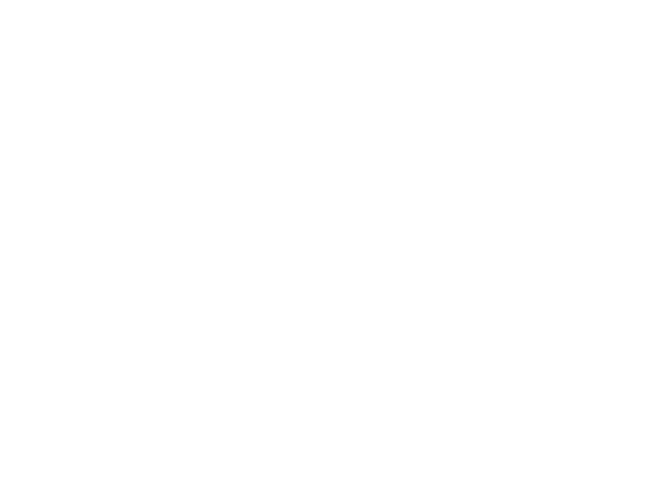

In [82]:
subnet=G.subgraph(subnet_nodes)
nx.draw(subnet)

In [25]:
protein.important_nodes_neighbour

{}

In [26]:
protein.important_nodes

{}

In [27]:
protein.important_nodes

{}

In [28]:
protein.homologue_index

[6, 8, 16, 14, 15, 10, 14, 17, 12, 16]

In [29]:
protein.partitions

[[{'4932.YAR035C-A',
   '4932.YBL001C',
   '4932.YBL012C',
   '4932.YBL044W',
   '4932.YBL083C',
   '4932.YBR022W',
   '4932.YBR032W',
   '4932.YBR046C',
   '4932.YBR071W',
   '4932.YBR144C',
   '4932.YBR196C-A',
   '4932.YBR197C',
   '4932.YBR203W',
   '4932.YBR209W',
   '4932.YBR255W',
   '4932.YBR259W',
   '4932.YBR266C',
   '4932.YBR298C-A',
   '4932.YBR300C',
   '4932.YCR102W-A',
   '4932.YDL242W',
   '4932.YDR215C',
   '4932.YGR247W',
   '4932.YIR040C',
   '4932.YJL222W-A',
   '4932.YJL222W-B',
   '4932.YKL098W',
   '4932.YLR087C',
   '4932.YLR296W',
   '4932.YMR126C',
   '4932.YNR072W',
   '4932.YOL118C',
   '4932.YOL119C',
   '4932.YOR285W',
   '4932.YPR027C',
   '4932.YPR153W'},
  {'4932.Q0045',
   '4932.Q0050',
   '4932.Q0055',
   '4932.Q0060',
   '4932.Q0065',
   '4932.Q0070',
   '4932.Q0075',
   '4932.Q0080',
   '4932.Q0085',
   '4932.Q0105',
   '4932.Q0110',
   '4932.Q0115',
   '4932.Q0120',
   '4932.Q0130',
   '4932.Q0250',
   '4932.Q0255',
   '4932.Q0275',
   '4932.YAL00

In [30]:
len([*G.neighbors("4932.YKL126W")])

35

In [31]:
from collections import Counter
from itertools import combinations

In [32]:
combs=[]
for part in protein.partitions:
    kk=map(lambda x: combinations(x,2),part)
    combs.append([*kk])

In [33]:
combed=sum(combs,[])

In [34]:
a=[*map(list,combed)]

In [35]:
len(a)

182

In [36]:
a1=sum(a,[])

In [37]:
len(a1)

9183859

In [38]:
a2=[*map(frozenset,a1)]

In [39]:
len(a2)

9183859

In [40]:
c1=Counter(a1)

In [41]:
len(c1)

1849108

In [42]:
c2=Counter(a2)
len(c2)

1701188

In [43]:
c2

Counter({frozenset({'4932.YBR298C-A', '4932.YOL119C'}): 4,
         frozenset({'4932.YBR144C', '4932.YBR298C-A'}): 5,
         frozenset({'4932.YAR035C-A', '4932.YBR298C-A'}): 2,
         frozenset({'4932.YBR298C-A', '4932.YPR153W'}): 2,
         frozenset({'4932.YBR298C-A', '4932.YDL242W'}): 4,
         frozenset({'4932.YBR298C-A', '4932.YKL098W'}): 2,
         frozenset({'4932.YBR203W', '4932.YBR298C-A'}): 5,
         frozenset({'4932.YBR022W', '4932.YBR298C-A'}): 5,
         frozenset({'4932.YBL012C', '4932.YBR298C-A'}): 5,
         frozenset({'4932.YBR298C-A', '4932.YMR126C'}): 2,
         frozenset({'4932.YBR046C', '4932.YBR298C-A'}): 5,
         frozenset({'4932.YBR032W', '4932.YBR298C-A'}): 4,
         frozenset({'4932.YBR298C-A', '4932.YJL222W-B'}): 5,
         frozenset({'4932.YBL044W', '4932.YBR298C-A'}): 5,
         frozenset({'4932.YBR255W', '4932.YBR298C-A'}): 2,
         frozenset({'4932.YBR298C-A', '4932.YLR296W'}): 5,
         frozenset({'4932.YBL001C', '4932.YBR298C-A'

In [44]:
index_list=enumerate(G)
index_dict1={i[0]:i[1] for i in index_list}
index_list=enumerate(G)
index_dict2={i[1]:i[0] for i in index_list}

In [45]:
index_part=[]
for part in protein.partitions:
    idx=[[index_dict2[n] for n in suba] for suba in part]
    index_part.append(idx)

In [46]:
combs_idx=[]
for part in index_part:
    kk=[combinations(x,2) for x in part]
    combs_idx+=kk

In [47]:
len(combs_idx)

182

In [48]:
aa=sum([*map(list,combs_idx)],[])

In [49]:
aa2=map(frozenset,aa)

In [50]:
cc=Counter(aa2)

In [51]:
len(cc)

1701188

In [52]:
dd=cc.copy()

In [53]:
sim_val=cc.values()

In [54]:
dis_val=np.array([*sim_val])

In [55]:
dis_val

array([4, 5, 2, ..., 1, 1, 1])

In [56]:
coord=[[*i] for i in cc.keys()]

In [57]:
coord_mat=np.array(coord)

In [58]:
coord_mat

array([[3762,  746],
       [3920, 3762],
       [3762, 4014],
       ...,
       [2656, 3321],
       [3321, 2906],
       [1473, 3926]])

In [59]:
row=np.concatenate((coord_mat[:,1],coord_mat[:,0]))
col=np.concatenate((coord_mat[:,0],coord_mat[:,1]))

In [60]:
import scipy as sp
import scipy.sparse as ss

In [61]:
dim=len(G.nodes)

In [62]:
dist=np.concatenate((dis_val,dis_val))

In [63]:
sim_mat=ss.coo_matrix((dist, (row, col)), shape=(dim,dim))

In [64]:
sim_mat

<4639x4639 sparse matrix of type '<class 'numpy.int64'>'
	with 3402376 stored elements in COOrdinate format>

In [65]:
sim_arr=sim_mat.toarray()

In [66]:
dis_arr=1-sim_arr/10

In [67]:
sim_arr[0]

array([ 0,  1, 10, ...,  0,  0,  0])

In [68]:
dis_arr

array([[1. , 0.9, 0. , ..., 1. , 1. , 1. ],
       [0.9, 1. , 0.9, ..., 1. , 1. , 1. ],
       [0. , 0.9, 1. , ..., 1. , 1. , 1. ],
       ...,
       [1. , 1. , 1. , ..., 1. , 0. , 0. ],
       [1. , 1. , 1. , ..., 0. , 1. , 0. ],
       [1. , 1. , 1. , ..., 0. , 0. , 1. ]])

In [69]:
np.fill_diagonal(dis_arr, 0)

In [70]:
condensed_dist=dis_arr[np.triu_indices(dis_arr.shape[0], k = 1)]

In [71]:
dis_arr.shape

(4639, 4639)

In [72]:
condensed_dist.shape

(10757841,)

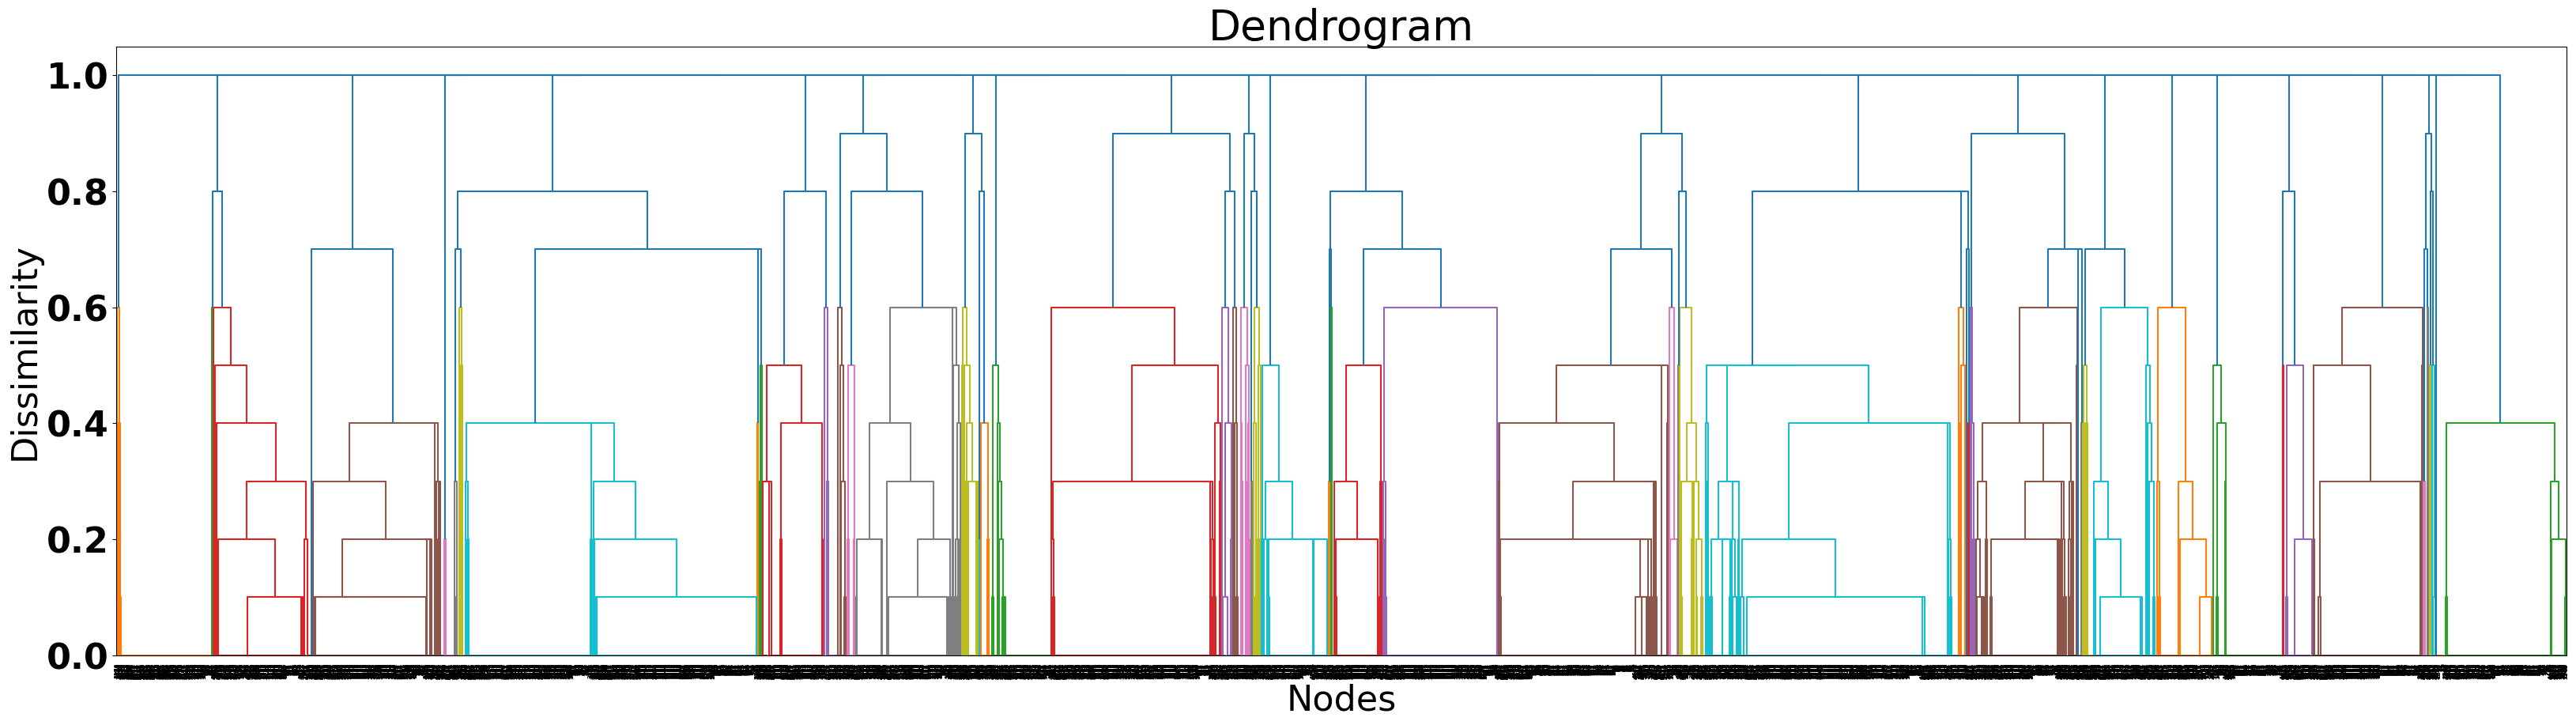

In [73]:
import scipy.cluster.hierarchy as sch
fig = plt.figure(figsize=(40, 10))
dendrogram = sch.dendrogram(sch.linkage(condensed_dist, method = 'complete')) # finding the optimal number of clusters using dendrogram
plt.title('Dendrogram') # title of the dendrogram
plt.xlabel('Nodes') # label of the x-axis
plt.ylabel('Dissimilarity') # label of the y-axis
plt.show() # show the dendrogram

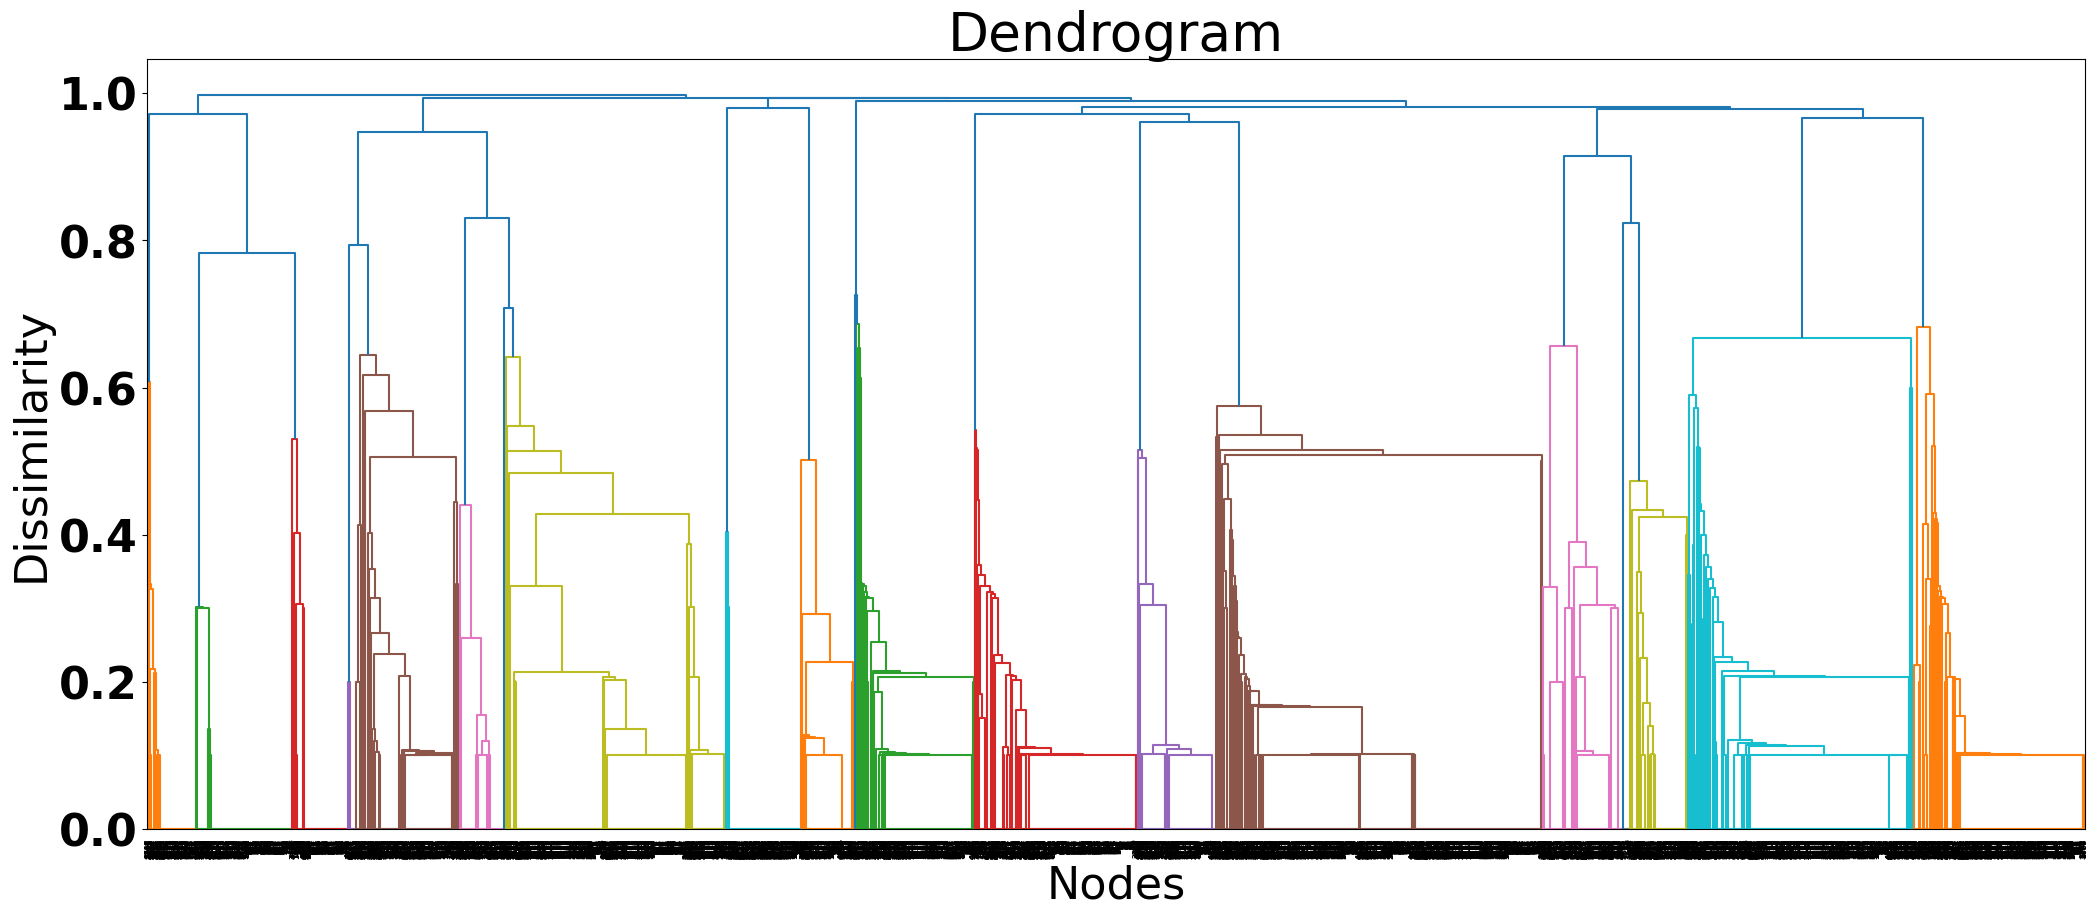

In [74]:
fig = plt.figure(figsize=(25, 10))
dendrogram = sch.dendrogram(sch.linkage(condensed_dist, method = 'average')) # finding the optimal number of clusters using dendrogram
plt.title('Dendrogram') # title of the dendrogram
plt.xlabel('Nodes') # label of the x-axis
plt.ylabel('Dissimilarity') # label of the y-axis
plt.show() # show the dendrogram

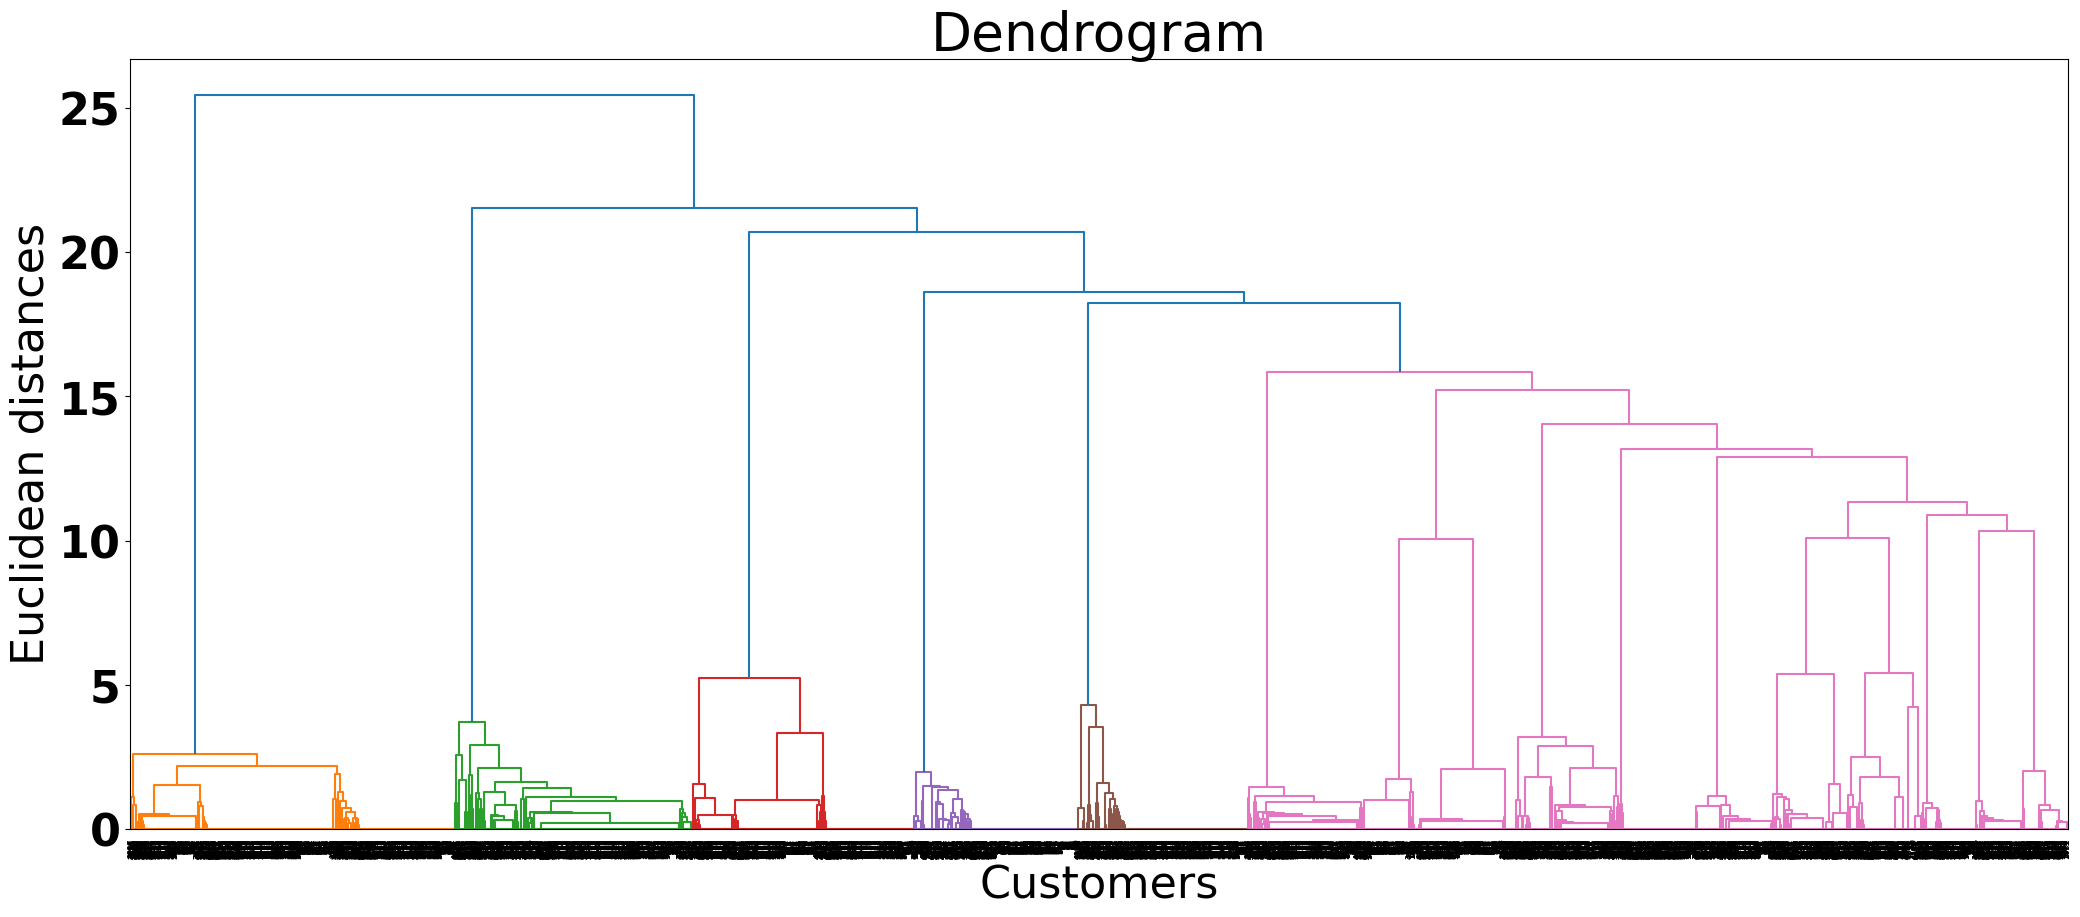

In [75]:
fig = plt.figure(figsize=(25, 10))
dendrogram = sch.dendrogram(sch.linkage(condensed_dist, method = 'ward')) # finding the optimal number of clusters using dendrogram
plt.title('Dendrogram') # title of the dendrogram
plt.xlabel('Customers') # label of the x-axis
plt.ylabel('Euclidean distances') # label of the y-axis
plt.show() # show the dendrogram

In [76]:
F=G.copy()

In [77]:
G

In [78]:
F

In [79]:
F=nx.relabel_nodes(F,index_dict2)

In [80]:
lnes=[*map(len,protein.partitions)]

In [81]:
from sklearn.cluster import AgglomerativeClustering

ModuleNotFoundError: No module named 'sklearn'

In [ ]:
hier_parts_complete=[]
hier_parts_avg=[]
for i in range(min(lnes),max(lnes)+1):
    c_mod=AgglomerativeClustering(n_clusters = i, affinity="precomputed",linkage="complete")
    hh=c_mod.fit_predict(dis_arr)
    hier_parts_complete.append(hh)
    c_moda=AgglomerativeClustering(n_clusters = i, affinity="precomputed",linkage="average")
    hha=c_moda.fit_predict(dis_arr)
    hier_parts_avg.append(hha)

In [ ]:
max(hier_parts_complete[0])

15

In [ ]:
th=hier_parts_complete[0]

In [ ]:
nodesF=np.array(list(F.nodes))

In [ ]:
def part_collector(hier):
    m=max(hier)
    coll=[set(nodesF[hier==i].tolist()) for i in range(m+1)]
    return coll
    
        

In [ ]:
mod_list=[]
for part in protein.partitions:
    modu=nx_comm.modularity(G,part)
    mod_list.append(modu)

In [ ]:
print(min(mod_list),max(mod_list))

0.6740729102426231 0.6799470278419141


In [ ]:
fpartC=[*map(part_collector,hier_parts_complete)]


In [ ]:
fpartA=[*map(part_collector,hier_parts_avg)]

In [ ]:
C_mod=[]
A_mod=[]
for part in fpartC:
    modul=nx_comm.modularity(F,part)
    C_mod.append(modul)

In [ ]:
C_mod

[0.6216660388459435,
 0.63219566918392,
 0.643720250050554,
 0.646078099662544,
 0.6733978793010285,
 0.6739881106805289]

In [ ]:
for part in fpartA:
    modul=nx_comm.modularity(F,part)
    A_mod.append(modul)

In [ ]:
A_mod

[0.6778906013742737,
 0.6778792162755618,
 0.6796685988505666,
 0.6796732550910342,
 0.6796802540971084,
 0.6796588707705655]

In [ ]:
intr=fpartA[4].copy()

In [ ]:
homo_idx=index_dict2['4932.YKL126W']

In [ ]:
[*map(lambda x: len(x.nodes),protein.homologue_communities)]

[532, 536, 508, 518, 522, 548, 512, 468, 520, 550]

In [ ]:
por_f=Network(F,homologue=homo_idx)

In [ ]:
por_f.homologue

1725

In [ ]:
por_f.partitions.append(intr)

In [ ]:
por_f.set_homologue_communities()

{3072, 1537, 3075, 2566, 3079, 3591, 1036, 3084, 528, 2579, 4630, 2586, 1051, 2076, 2589, 2079, 2080, 1574, 1576, 1577, 4138, 2604, 557, 1581, 3630, 1072, 2097, 2608, 4141, 2105, 582, 1097, 2635, 3147, 2639, 2128, 4178, 2132, 1622, 2647, 2139, 2652, 1117, 3071, 4188, 609, 1121, 4194, 612, 3686, 1641, 1654, 1656, 1657, 4216, 1148, 1660, 1662, 3711, 1665, 1666, 1156, 1669, 1158, 2694, 1162, 1163, 1164, 3211, 1678, 4239, 1686, 1175, 3224, 1179, 1180, 2204, 2205, 1695, 2715, 3233, 4258, 1702, 4262, 2216, 1705, 1709, 1710, 4269, 2227, 2230, 2231, 2744, 2235, 1724, 4289, 3267, 200, 1736, 1738, 1740, 3286, 728, 3800, 1755, 1756, 2269, 2782, 3806, 3808, 1250, 741, 2789, 3301, 1768, 3819, 3820, 2285, 2798, 3310, 2291, 3315, 3318, 2807, 3319, 3320, 251, 765, 1789, 1791, 3329, 4355, 4356, 3333, 4359, 2312, 3342, 3343, 2838, 1304, 1305, 1818, 2329, 2842, 1310, 1825, 1827, 294, 2854, 3366, 3370, 1325, 3377, 3378, 1843, 1844, 3381, 3889, 1847, 3384, 3385, 4405, 1851, 3388, 321, 1858, 3912, 1867, 391

In [ ]:
por_f.homologue_index

[4]

In [ ]:
por_f.find_neighbours()
por_f.set_neighbour_communities()

In [ ]:
len(por_f.adjacent_communities[0])

19

In [ ]:
por_f.set_central_nodes_robust()

In [ ]:
por_f.central_nodes[0]

[1700, 2725, 108, 1903, 1841, 1716, 2745, 1948, 1885, 1471]

In [ ]:
[index_dict1[x] for x in por_f.central_nodes[0]]

['4932.YHR030C',
 '4932.YLR362W',
 '4932.YJR066W',
 '4932.YDR477W',
 '4932.YGR040W',
 '4932.YLR113W',
 '4932.YHL007C',
 '4932.YMR307W',
 '4932.YBL016W',
 '4932.YLR433C']

In [ ]:
k=[*por_f.central_nodes_neighbour[0]].copy()

In [ ]:
n_im=[[index_dict1[x] for x in y] for y in k]

In [ ]:
n_im

[['4932.YMR125W',
  '4932.YBR169C',
  '4932.YPL106C',
  '4932.YDL160C',
  '4932.YPL178W'],
 ['4932.YDR388W', '4932.YML001W', '4932.YAL030W', '4932.YOR089C'],
 ['4932.YMR304C-A',
  '4932.YJR146W',
  '4932.YPR089W',
  '4932.YOL048C',
  '4932.YPR197C'],
 ['4932.YBR010W',
  '4932.YMR190C',
  '4932.YOL012C',
  '4932.YER095W',
  '4932.YML032C'],
 ['4932.YMR250W', '4932.YMR105C', '4932.YGR088W'],
 ['4932.YBR170C',
  '4932.YDR483W',
  '4932.YDL190C',
  '4932.YOL013C',
  '4932.YAL023C'],
 ['4932.YLR364W',
  '4932.YER145C',
  '4932.YPL059W',
  '4932.YGL071W',
  '4932.YMR058W'],
 ['4932.YJR121W',
  '4932.YOR065W',
  '4932.YGL226W',
  '4932.YEL024W',
  '4932.YGR183C'],
 ['4932.YLR287C',
  '4932.YML014W',
  '4932.YBL024W',
  '4932.YDL201W',
  '4932.YOR154W'],
 ['4932.YLL013C',
  '4932.YGR220C',
  '4932.YPL013C',
  '4932.YDR036C',
  '4932.YBR146W',
  '4932.YKL194C'],
 ['4932.YKR089C',
  '4932.YMR165C',
  '4932.YER015W',
  '4932.YGL205W',
  '4932.YOR081C',
  '4932.YOL147C'],
 ['4932.YGL013C',
  '4932

In [ ]:
# nodes_n=protein.adjacent_communities[0]
# "4932.YKL126W" in [y for x in nodes_n for y in x]

In [ ]:
# len(nodes_n)

15

In [ ]:
a=protein.partitions[0]
len(a)

16

In [ ]:
ypk1=Network(G,homologue='4932.YKL126W')

In [ ]:
ypk1.get_important_nodes()

{'4932.YGR040W': {'times_occured': 9, 'distance': 4},
 '4932.YJR066W': {'times_occured': 9, 'distance': 2},
 '4932.YLR113W': {'times_occured': 9, 'distance': 3},
 '4932.YBL016W': {'times_occured': 9, 'distance': 4},
 '4932.YLR362W': {'times_occured': 9, 'distance': 3},
 '4932.YHR030C': {'times_occured': 9, 'distance': 3},
 '4932.YDR477W': {'times_occured': 9, 'distance': 3},
 '4932.YNL098C': {'times_occured': 7, 'distance': 3},
 '4932.YHL007C': {'times_occured': 7, 'distance': 3},
 '4932.YMR307W': {'times_occured': 4, 'distance': 3},
 '4932.YLR433C': {'times_occured': 5, 'distance': 3},
 '4932.YKL113C': {'times_occured': 1, 'distance': 4},
 '4932.YHL022C': {'times_occured': 1, 'distance': 4},
 '4932.YML032C': {'times_occured': 1, 'distance': 4},
 '4932.YBR010W': {'times_occured': 1, 'distance': 3},
 '4932.YMR190C': {'times_occured': 1, 'distance': 4},
 '4932.YER095W': {'times_occured': 1, 'distance': 3},
 '4932.YOR033C': {'times_occured': 1, 'distance': 4},
 '4932.YOL012C': {'times_occ

In [ ]:
subnet_nodes=[*{node:ypk1.homologue_members[node] for node in ypk1.homologue_members if ypk1.homologue_members[node]>=9}.keys()]

In [ ]:
len(subnet_nodes)

355

In [ ]:
subnet=G.subgraph(subnet_nodes)

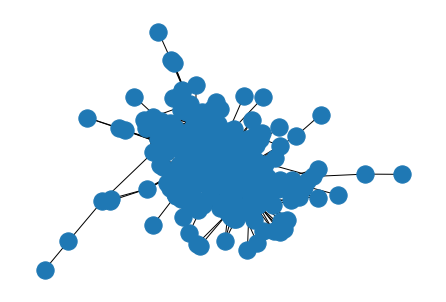

In [ ]:
nx.draw(subnet)